# Project 4: Image Classification and Feature Extraction
---

## Assignments

Please, edit your report by fulfilling the following list of assignments.

**Introduction.** Short summary of the goals of the  project. The sections composing the report.

**Section 1. Data loading and preparation**

Download, decompress, analyse:

https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

* 1a. Download the dataset;
* 1b. Load the dataset and check its characteristics;
* 1c. Show the first 4 images for each category;
* 1d. Data preparation.

**Section 2. The AlexNet model** 
* 2a. Download the net, not pre-trained.

**Section 3. Training the Net**
* 3a. Design the architecture;
* 3b. Define the batch size and load the training and test set;
* 3c. Define a training function;
* 3d. Run the training;
* 3e. Save the trained network.

**Section 4. Test and performance evaluations**
* 4a. Define and execute a test function;
* 4b. Performance curves.

**Section 5. Extracting features**
* 5a. Load the saved network and set it in evaluation mode;
* 5b. Visualize the learned kernels of the first convolutional layer;
* 5c. Visualize the feature maps.

**Results, Observations and Conclusions**
Write your own notes, observations and conclusions about the results of your work.

**Full Code**
Report the complete code of the project.

## Introduction


## 1. Data loading and preparation

Import the libraries.

In [1]:
!pip install torch-inspect

  Created wheel for torch-inspect: filename=torch_inspect-0.0.3-cp37-none-any.whl size=9606 sha256=c01a1f0a803400f5c10c7f5605e9e4b047315e6a233de1fe2746d5777dd820a9
  Stored in directory: /root/.cache/pip/wheels/3c/82/c8/bbf58be133c90df17979dfdbfc7f3062d9a9e611baeeb3a433
Successfully built torch-inspect


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

# 1a. Download the dataset
from torchvision.datasets.utils import download_and_extract_archive

# 2a. (show AlexNet structure)
import torch_inspect as ti 

Define the device to use during the computation.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 1a. Download the dataset
Description of the dataset: [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers).

In [4]:
# download flower_photos  
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz" #URL to download file from
filename = "flower_photos.tgz" #name to save the file under
root = "~/tmp/" #directory to place downloaded file in
download_and_extract_archive(url, root, filename)


Extracting /root/tmp/flower_photos.tgz to flower_photos.tgz


### 1b. Load the dataset and check its characteristics

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# load the dataset 
data = torchvision.datasets.ImageFolder(root='flower_photos.tgz/flower_photos/', 
                                           transform=transform)

# check the dataset size and get the names of the classes
print("Dataset size:", len(data))
print("Classes:", data.classes)

Dataset size: 3670
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#### Summarize the number of images for each category and display the summary in a table

In [6]:
# calculate the number of samples in each class:
_, imgs_per_class = torch.unique(torch.tensor(data.targets), return_counts=True)

# print the number of elements in each class
for label, num_of_imgs in zip(data.classes, imgs_per_class):
  print("There are {} elements in the class '{}'".format(num_of_imgs,label))

There are 633 elements in the class 'daisy'
There are 898 elements in the class 'dandelion'
There are 641 elements in the class 'roses'
There are 699 elements in the class 'sunflowers'
There are 799 elements in the class 'tulips'


#### Print the resolution of the first image for each category

Note that the samples are arranged per class, meaning that the first N images belong to class 0, the following M elements belong to the class 1, and so on.

In [7]:
NUM_CLASSES = len(data.classes)

# create a dictionary that maps the labels (integers) to the name of the class
labels_dict = dict(zip(range(NUM_CLASSES), data.classes))

# create a list with the indices of the first image of each class
from itertools import accumulate 
first_image_per_class = list(accumulate(imgs_per_class))
first_image_per_class.pop()
first_image_per_class.insert(0,0)

# print the resolution of the first image for each category
for i in first_image_per_class:
  img, label = data[i]
  print("The image resolution for the first {} image is: {}x{}".format(
      labels_dict[label], 
      img.shape[1], 
      img.shape[2]))

The image resolution for the first daisy image is: 263x320
The image resolution for the first dandelion image is: 213x320
The image resolution for the first roses image is: 240x179
The image resolution for the first sunflowers image is: 330x500
The image resolution for the first tulips image is: 209x320


### 1c. Show the first 4 images for each category
Print them in a grid with 4 columns (samples) and 5 rows (classes).

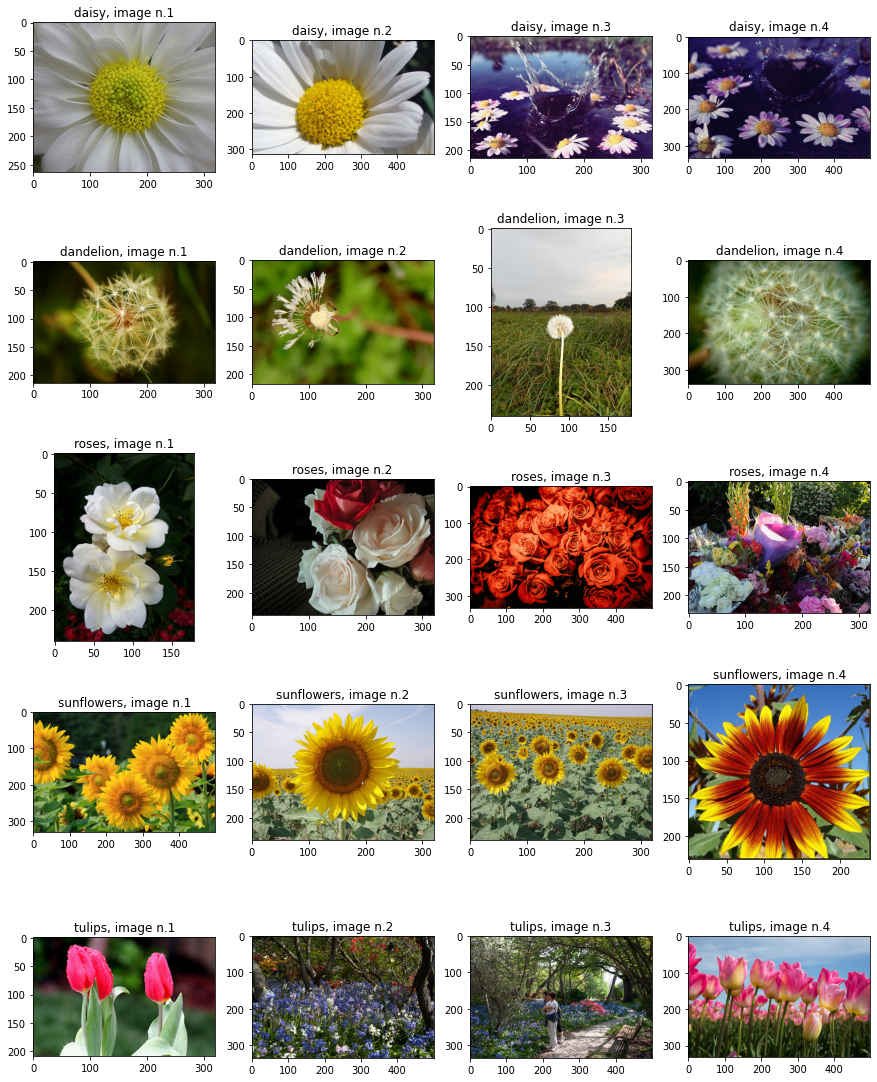

In [8]:
figure = plt.figure(figsize=(15, 20))
cols, rows = 4, 5

# prints the images per row
for i in range(rows):
    for j in range(1, cols+1):
        img, label = data[first_image_per_class[i]+j-1]
        figure.add_subplot(rows, cols, i+j+(i*3))
        plt.title("{}, image n.{}". format(labels_dict[label], j))
        plt.imshow(np.clip(img.permute(1,2,0), 0., 1.))
plt.show()

### 1d. Data preparation

#### Load and normalize the data

Normalize the pixel values and resize the images to 64x64 pixels.

To normalize ([documentation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize)) the tensor images, calculate the mean and standard deviation for the 3 colour channels of the images over the entire dataset.

In [9]:
IMGS_DIM = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMGS_DIM, IMGS_DIM)) #resize all images to IMGS_DIMxIMGS_DIM pixels
])

# load the dataset 
data = torchvision.datasets.ImageFolder(root='flower_photos.tgz/flower_photos/', 
                                           transform=transform)

# stack all the images by iterating over the dataset and extract the images
imgs = torch.stack([img for img, _ in data], dim=3)
print(imgs.shape)

# keep 3 channels and merge all the remaining dimensions into one 
temp = imgs.view(3, -1)
print(temp.shape)

# calculate the mean over the elements of each channel
mean = temp.mean(dim=1)

# calculate the standard deviation over the elements of each channel
std = temp.std(dim=1)

print(mean, std)

torch.Size([3, 64, 64, 3670])
torch.Size([3, 15032320])
tensor([0.4665, 0.4251, 0.3040]) tensor([0.2992, 0.2699, 0.2933])


Use these values to normalize our data.

In [10]:
IMGS_DIM = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std), #normalize the pixel values
    transforms.Resize((IMGS_DIM, IMGS_DIM)) #resize all images to IMGS_DIMxIMGS_DIM pixels
])

## TODO: load the dataset into the 'data' variable as before
data = torchvision.datasets.ImageFolder(root='flower_photos.tgz/flower_photos/', 
                                           transform=transform)

#### Constrain to 70 the number of images per category. Check this by printing a table

In [11]:
# get all the first 70 indices for each class
indices = []
for i in range(len(first_image_per_class)):
  indices += list(range(first_image_per_class[i], first_image_per_class[i]+70))

# create a subset of the original dataset with just 70 samples per class
data2 = torch.utils.data.Subset(data, indices)

# check if the size is 70x5=350
print("Dataset size:", len(data2))
print()

# check if each class contains 70 elements
from collections import Counter
data2_classes = [label for _, label in data2] # list of all the labels (classes) in data2
imgs_per_class_in_data2 = dict(Counter(data2_classes)) # count how many elements per class

for k, v in imgs_per_class_in_data2.items():
  print("There are {} elements in the {} class".format(v, labels_dict[k]))

Dataset size: 350

There are 70 elements in the daisy class
There are 70 elements in the dandelion class
There are 70 elements in the roses class
There are 70 elements in the sunflowers class
There are 70 elements in the tulips class


#### Define the Training and Test sets (300/50) and randomize the images

Define the size of the training set and test set, and construct them randomizing the images using `random_split`.

In [12]:
train_size = 300
test_size = 50

train_set, test_set = torch.utils.data.random_split(data2, [train_size, test_size])

# check training set and test set size
print("Training set size:", len(train_set)) # 300
print("Test set size:", len(test_set))      # 50

Training set size: 300
Test set size: 50


## 2. The AlexNet model

### 2a. Download the net, not pre-trained
Go to the [AlexNet page](https://pytorch.org/hub/pytorch_vision_alexnet/) on the PyTorch website and load the model.

In [13]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=False)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip


#### Show in your report a table with its structure
Visualize the network structure. Use the `torch-inspect` library ([PyPI](https://pypi.org/project/torch-inspect/), [GitHub](https://github.com/jettify/pytorch-inspect)) to visualize the network structure in more detail.

In [14]:
model.eval()
print()
ti.summary(model, (3, 64, 64))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [2, 64, 15, 15]          23,296
              ReLU-2            [2, 64, 15, 15]               0
         MaxPool2d-3              [2, 64, 7, 7]               0
            Conv2d-4             [2, 192, 7, 7]         307,392
              ReLU-5             [2, 192, 7, 7]               0
         MaxPool2d-6             [2, 192, 3, 3]               0
            Conv2d-7             [2, 384, 3, 3]         663,936
              ReLU-8             [2, 384, 3, 3]               0
            Conv2d-9             [2, 256, 3, 3]         884,992
             ReLU-10             [2, 256, 3, 3]               0
           Conv2d-11             [2, 256, 3, 3]         590,080
             ReLU-12             [2, 256, 3, 3]               0
        MaxPool2d-13             [2, 256, 1, 1]               0
AdaptiveAvgPool2d-14             [2,

NetworkInfo(total_params=61100840, trainable_params=61100840, total_input_size=98304, total_output_size=1740416, total_params_size=244403360, total_size=246242080)

## 3. Training the Net

### 3a. Design the architecture
We modify some of the AlexNet layers to better suit our dataset. Consult the [documentation](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html).

In [15]:
# first convolutional layer
model.features[0] = nn.Conv2d(3, IMGS_DIM, kernel_size=7, stride=2, padding=3)

# last linear layer (classifier)
model.classifier[6] = nn.Linear(4096,5)

Visualize the modified architecture.

In [16]:
print(model.eval())

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

### 3b. Define the batch size and load the training and test set
We define a batch size of 4, and load the training set and test set with `DataLoader`.

In [17]:
BATCH_SIZE = 4

# load the training set and the test set
train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

### 3c. Define a training function
Define a training function to loop over the epochs. First, specify the number of epochs (80) and the learning rate (0.01). Then, use the Stochastic Gradient Descent (SGD) as the optimization algorithm and the `CrossEntropyLoss` as thr performance estimate.


In [18]:
NUM_EPOCHS = 80
LEARNING_RATE = 0.01

# the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
# the loss function
error = nn.CrossEntropyLoss()

# the training function
def train(model, train_loader, NUM_EPOCHS):
    train_loss = [] #list to memorize the loss values
    for epoch in range(NUM_EPOCHS): #loop over the epochs  
        running_loss = 0.0
        for images, labels in train_loader:
            # get the inputs and load them to the computation device 
            images, labels = images.to(device), labels.to(device)

            # set the gradients to zero
            optimizer.zero_grad()

            # feedforward pass
            outputs = model(images)
            loss = error(outputs, labels)

            # backpropagation
            loss.backward()

            # update the parameters
            optimizer.step()

            running_loss += loss.item()

        # calculate the loss value and add it to the list    
        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        # keep track of the training process
        print('Epoch {} of {}, Train Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss))

    return train_loss

### 3d. Run the training

In [19]:
model.to(device)

train_loss = train(model, train_loader, NUM_EPOCHS)

Epoch 1 of 80, Train Loss: 1.6099
Epoch 2 of 80, Train Loss: 1.6074
Epoch 3 of 80, Train Loss: 1.6054
Epoch 4 of 80, Train Loss: 1.6036
Epoch 5 of 80, Train Loss: 1.5998
Epoch 6 of 80, Train Loss: 1.5926
Epoch 7 of 80, Train Loss: 1.5793
Epoch 8 of 80, Train Loss: 1.5404
Epoch 9 of 80, Train Loss: 1.4326
Epoch 10 of 80, Train Loss: 1.3762
Epoch 11 of 80, Train Loss: 1.3354
Epoch 12 of 80, Train Loss: 1.3005
Epoch 13 of 80, Train Loss: 1.2699
Epoch 14 of 80, Train Loss: 1.2666
Epoch 15 of 80, Train Loss: 1.2343
Epoch 16 of 80, Train Loss: 1.1835
Epoch 17 of 80, Train Loss: 1.1560
Epoch 18 of 80, Train Loss: 1.1449
Epoch 19 of 80, Train Loss: 1.0812
Epoch 20 of 80, Train Loss: 1.0954
Epoch 21 of 80, Train Loss: 1.0604
Epoch 22 of 80, Train Loss: 1.0239
Epoch 23 of 80, Train Loss: 1.0300
Epoch 24 of 80, Train Loss: 0.9708
Epoch 25 of 80, Train Loss: 0.9618
Epoch 26 of 80, Train Loss: 0.9009
Epoch 27 of 80, Train Loss: 0.8956
Epoch 28 of 80, Train Loss: 0.8243
Epoch 29 of 80, Train Loss: 0

### 3e. Save the trained network

In [47]:
# save the model
print("Saving the model...")

try:
    torch.save(model.state_dict(), "AlexNet_flowers_saved_network.pth")
    print("Model saved!")
except:
    print("Could not save the model")

Saving the model...
Model saved!


## 4. Test and performance evaluations


In [23]:
# set the model in evaluation mode
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

### 4a. Define and execute a test function

Define a test function that calculates the accuracy of the trained network by giving it as inputs the test set. While doing so, print the first 2 batches of images of the test set; check whether their class prediction is correct; print the predicted class as compared the right one.

In [42]:
def test(model, test_loader):
    predictions_list = [] 
    total = 0
    correct = 0
    batch = 1 #batch counter
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images) #prediction on the trained network

        predictions = torch.max(outputs, 1)[1].to(device) #get the predicted class
        predictions_list.append(predictions) #append the predicted class to the list
        correct += (predictions == labels).sum() #increase the correct predictions counter
                                                 #when the prediction matches the correct label
        total += len(labels) 
        images = images.cpu()

        if batch <= 2: #print the images only for the first 2 batches
            figure = plt.figure(figsize=(15, 20))
            cols, rows = BATCH_SIZE, 1
            for j in range(cols):
                # visualize the images of the batch
                figure.add_subplot(rows, cols, j+1)
                if labels[j] == predictions_list[batch-1][j]: #for each image, check if
                    pred = "CORRECT"                          #it was correctly predicted
                else:
                    pred = "WRONG"
                plt.title("Correct class: {}\nPredicted class: {}\nPrediction: {}". format(labels_dict[labels[j].item()], 
                                                                                           labels_dict[predictions_list[batch-1][j].item()],
                                                                                           pred))
                plt.imshow(np.clip(images[j].permute(1,2,0), 0., 1.))
        batch += 1

    accuracy = correct * 100 / total #calculate the accuracy

    return accuracy

#### Execute the test function and print the accuracy value

Accuracy: 58.00%


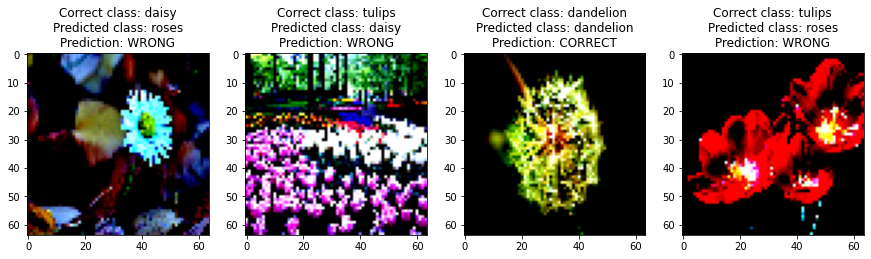

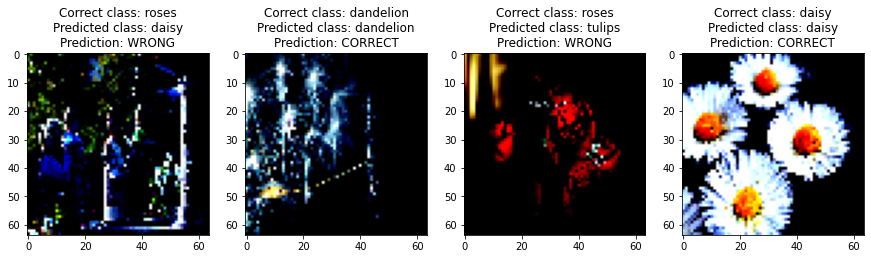

In [43]:
accuracy = test(model, test_loader)

print("Accuracy: {:.2f}%".format(accuracy.item()))

### 4b. Performance curves
Plot the loss and accuracy curve.

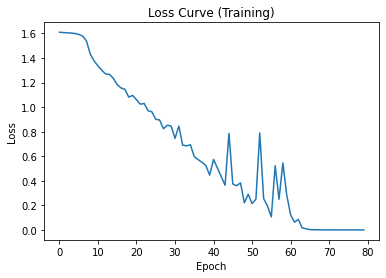

In [44]:
# loss curve
plt.figure()
plt.plot(train_loss)
plt.title('Loss Curve (Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 5. Extracting features

### 5a. Load the saved network and set it to evaluation mode

Read about saving and loading models in the [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

It's more convenient to save the model using `state_dict` (see section **3e. Save the trained network**):
```
torch.save(model.state_dict(), PATH)
```

Steps to take to load a model, especially if you open this notebook and it's not already connected to a runtime (namely, you don't have any executed code, so no defined variables, etc):
* upload to Colab the `AlexNet_flowers_saved_network.pth` file using the file browser on the left side panel (select `Files` tab > click on `Upload to session storage`);
* run all the code blocks BEFORE the training. This will re-define the model structure, which is needed to load the model;
* use `model.load_state_dict(torch.load(PATH))` to load the model (remember to read the [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html)).


In [48]:
model.load_state_dict(torch.load("AlexNet_flowers_saved_network.pth"))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

### 5b. Visualize the learned kernels of the first convolutional layer

#### Extract the convolutional layers from the model

Create a list called `layers_list` to save the desired layers. Add to this list the first 2 convolutional layers. 

Then, save into a variable (`first_conv_layer_filters`) the weights of the filters of the first convolutional layer.

In [49]:
# get all the model children as list
model_children = list(model.children())

layers_list = [] # list to save the layers in
# add to the list the desired layers 
layers_list.extend([model_children[0][0], 
                    model_children[0][3]
                   ]) 

# weights of the first convolutional layer
first_conv_layer_filters = model_children[0][0].weight

Print the layers in `layers_list` to check them.

In [50]:
for layer in layers_list:
    print(layer)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))


#### Visualize the first convolutional layer filters

Visualize 16 of the first convolutional layer filters in a 4x4 grid.

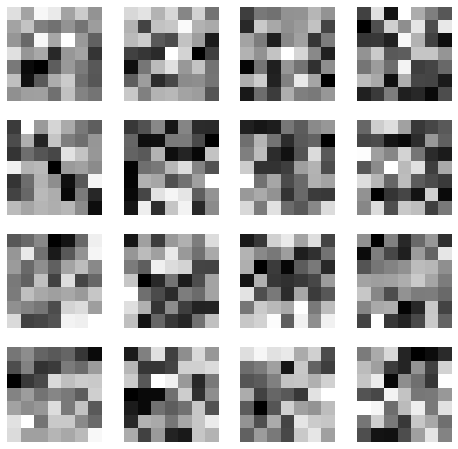

In [51]:
# visualize 16 of the the first convolutional layer kernels
plt.figure(figsize=(8, 8)) #set the width and height of the figure
for i, filter in enumerate(first_conv_layer_filters): #loop over the kernels in the first conv layer
    if i < 16: #we want to visualize only 16 kernels
        # plot a filter
        plt.subplot(4, 4, i+1) 
        plt.imshow(filter[0, :, :].detach().cpu(), cmap='gray')
        plt.axis('off')
plt.show()

### 5c. Visualize the feature maps

#### Get an image from the test set
Get a random image from the test set and visualize it.

torch.Size([1, 3, 64, 64])


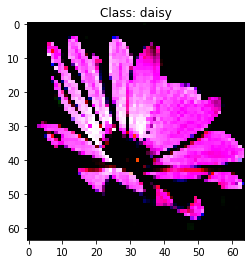

In [67]:
# get an image and its label from the test set
for test_image, test_label in test_loader:  
    img, label = test_image[0].unsqueeze(0), test_label[0]

# check the image size
print(img.size())

# visualize the image
img_show = img.squeeze().permute(1,2,0)
img_show = np.clip(img_show, 0., 1.)
plt.imshow(img_show)
# get and print as title the image label
plt.title("Class: {}".format(labels_dict[label.item()]))
plt.show()

#### Pass the input image through each convolutional layer
Pass the image through the layers in `layers_list`.

In [68]:
pass_first_conv = layers_list[0](img.to(device)) #image passed through the first conv layer
pass_second_conv = layers_list[1](pass_first_conv) #output of first conv layer passed
                                                   #through the second conv layer

outputs = [pass_first_conv, pass_second_conv]

#### Visualize the feature maps from the 1st, 2nd and last convolutional layer

Visualize 16 feature maps from the first, the second, and the last convolutional layer. Note that each of the layers has more than 16 feature maps, but we want to show only 16 to visualize them better. 

Convolutional layer n.1
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
Size: torch.Size([64, 32, 32])


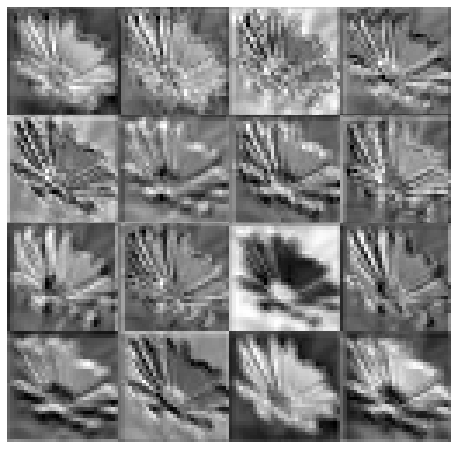

Convolutional layer n.2
Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Size: torch.Size([192, 32, 32])


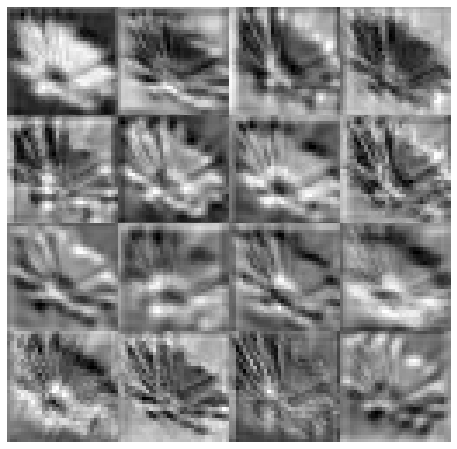

In [70]:
# visualize 16 features from each layer 
# (although there are more feature maps in each layer)
for num_layer in range(len(outputs)):
    # skip undesired layers
    if (num_layer == 2) or (num_layer == 3):
        pass
    else:
        plt.figure(figsize=(8, 8))
        # get all the feature maps (filters) of the corresponding layer
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print("Convolutional layer n.{}\n{}\nSize: {}".format(num_layer+1, 
                                                              layers_list[num_layer],
                                                              layer_viz.size()))
        # iterate through the filters in each layer_viz
        for i, filter in enumerate(layer_viz):
            if i == 16: # visualize only 4x4 blocks from each layer
                break
            plt.subplot(4, 4, i + 1)
            plt.imshow(filter.cpu(), cmap='gray')
            plt.axis("off")
        # tile the images (e.g. no white space between them)
        plt.subplots_adjust(hspace=-.02, wspace=-.02)
        plt.show()

#### Visualize the feature map from the last linear layer 
Visualize the output image from the network, that is the output from the last linear layer, the last feature map.

Predicted class: roses

Last linear layer (Classifier)


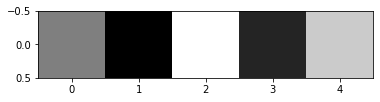

In [73]:
# "feed" the image to the network, and get an output (prediction)
out = model(img.to(device))

# get the predicted class.
# Since the output tensor is 1x5, and each of the 5 values is the probability
# of the image to belong to a given class, getting the maximum value between
# the 5 gives us the predicted class.
pred_class = labels_dict[torch.argmax(out).item()]
print("Predicted class: {}".format(pred_class))

# visualize the feature map
print("\nLast linear layer (Classifier)")
out_show = out.cpu().detach().numpy()
plt.imshow(out_show, cmap='gray')
plt.show()

## Results, Observations and Conclusions



## Full Code

---
## Bibliography

* [Visualizing Filters and Feature Maps in Convolutional Neural Networks using PyTorch](https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/)